**Foreword**<br><br>
Scipy can do the optimization. Numpy can find out the metrics we need.<br>
<br>
All we need to do is to understand and derive Portfolio Variance & Sharpe Ratio.<br>

**Portfolio Variance**

First, we consider a single stock portfolio.<br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$Var(x) = \frac{1}{n} \sum \limits _{i=1} ^{n}(x _i- \bar{x})^2$<br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;$ = E[x-E(x)]^2$, statiscally speaking.<br>
<br>
In short, it measures how far the data points deviates from its mean.<br>
If we apply this concept to stock price, the higher the variance, the more fluctuated the price.<br>
<br>
When it comes to variance of 2 variables, covariance should be taken in to considerataion.<br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$ Var(x+y) = E[(x+y)-E(x+y)]^2 $ <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$= E[[(x-E(x)] + [y-E(y)]]^2$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$= E[x-E(x)]^2 + E[y-E(y)]^2 + 2E[x-E(x)]E[y-E(y)]$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$= Var(x) + Var(y) + 2cov(x,y)$<br>
<br>
In stock allocation analysis, stock prices should be adjusted to the same scale.<br>
Therefore, we use daily return $r$ derived from time series of stock price.<br>
Also, the return should be multiplied by a weight factor $w$.<br>
Then the portfolio variance can be derived as follows.<br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$ Var(Portfolio) = Var(w^T r) $&emsp;where $w$ is the column vector of stock's weight<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&ensp;$=w^T \Sigma  w$ &emsp;&ensp;&nbsp;where $\Sigma $ is the covariance matrix of $r$

**Sharpe Ratio**

It is defined as follws.<br>
The excess portfolio return over risk free rate per unit of variance taken.<br>
The higher the Sharpe, the better the performance.<br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$ [E(w^T r)  -  r _f]$&ensp; / &ensp;$Var(w^T r) $ &emsp;&ensp;&nbsp;where  $r$ is the column vector of expected returns $E[w^T r]$ is portfolio return <br>
<br>
Now we need to optimize $w$, given $\Sigma$ and $E[r]$, which are derived from raw  stock data.

**Load stock data**

In [2]:
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf  
import numpy as np
import pandas as pd
from scipy import optimize

# get data n years from today
def get_price(portfolio,n):
    t_0 = datetime.today() - timedelta(365*n)
    return yf.download(portfolio,start=t_0)['Adj Close'][portfolio].to_numpy()
    # convert adj_close_price to a matrix, [portfolio] sorts column according to sequence in [portfolio]

**Get metrics from raw data and construct Portfolio Return and Variance**<br>
Also the correlation matrix between stocks as reference.

In [4]:
def hist_return_cov_corr(price):
    returns = (price[1:,:] / price[:-1,:])            # convert adj_close_price to daily returns
    returns = returns[~np.isnan(returns).any(axis=1)] # remove row with nan, along the row (axis=1)
    
    return  np.mean(returns,axis=0)**253-1, np.cov(np.transpose(returns))*253, np.corrcoef(np.transpose(returns)) 
            # annualized mean return        # annualized covariance matrix     # correlation matrix   
        
def portfolio_return(w,r):
    return np.dot(np.transpose(w),np.transpose(r))

def portfolio_var(w,cov):
    return np.dot(np.dot(np.transpose(w),cov),w)

**Optimize** $w$ **by Scipy to:**<br>
**1. Maximize Sharpe Ratio**<br>
**2. Minimize Variance without short selling**<br>

In [5]:
def max_sharpe_weight_no_ss(cov, r, rf):
    n = len(cov)
    w = np.ones([n])/n                      # initialize with equal weights
    bound = [(0,1) for i in range(n)]       # weights between 0-1 if short selling is not allowed 
    constraint = ({'type':'eq', 'fun': lambda w: sum(w)-1 })   # Sum of weights = 1
    
    def sharpe(w, cov, r, rf):
        sr = (portfolio_return(w,r)-rf)/portfolio_var(w,cov)
        return 1/sr
        
    ans = optimize.minimize(sharpe, w, (cov,r,rf), method='SLSQP', constraints=constraint,bounds=bound)  
    return ans.x

def min_var_weight_no_ss(cov):
    n = len(cov)
    w = np.ones([n])/n                      # initialize with equal weights
    bound = [(0,1) for i in range(n)]       # weights between 0-1 if short selling is not allowed 
    constraint = ({'type':'eq', 'fun': lambda w: sum(w)-1 })   # Sum of weights = 1
    
    # variance function of portfolio = w'*sigma*w
    def var(w, cov):
        return np.dot(np.dot(np.transpose(w) ,cov),w) 

    ans = optimize.minimize(var, w, (cov), method='SLSQP', constraints=constraint,bounds=bound)  
    return ans.x

**If we want to minimize variance and allow short selling, just remove the constraint in the fucntion min_var_weight_no_ss**<br><br>
For study purpose, I introduce Langrange Multiplier here.<br>
We are now subjected to 2 constaints only.<br>
<br>
$1.$ Minimize $Var(w^T r)$<br>
$2.$ $w^T$ **1 $= 1$, &emsp;1** is column vector of 1<br>
<br>
They are both function of $w$, denoted as $f(w_ 1, w _2,...w _i)$ <br>
<br>
Since the gradient vector is perpendicular to the function, at the point the 2 functions are tangential to each other  , 2 gradient vectors must be perpendicular to each other.<br><br>
This results <br><br>
$Gradient [Var(w^T r)]$ = $\lambda$ $Gradient$($w^T$ **1** - 1), for some scalar $\lambda$ <br><br>
more info for gradient vector: https://www.math.uic.edu/persisting_utilities/coursepages/math210/labpages/lab5<br>
more info for Langrange Multiplier: http://tutorial.math.lamar.edu/Classes/CalcIII/LagrangeMultipliers.aspx<br>

After some algebra,<br><br>
$w =$ $\frac{ \Sigma^{-1}\mathbb{1} }{ (\Sigma^{-1}\mathbb{1})^T \mathbb{1}  }$

In [6]:
def min_var_weight_LM(cov):
    inv_cov = np.linalg.pinv(cov)
    ones = np.ones(len(inv_cov))
    inv_dot_ones = np.dot(inv_cov, ones)
    return inv_dot_ones/np.dot(np.transpose(inv_dot_ones),ones)

**Here I try US stocks from different sectors.**<br>
**There are more to explore such as set of global indices, FX or cryptocurrency.**<br><br>
From the result below:<br>
If you want stability, allocate more on P&G, AT&T.<br>
If you want higher Sharpe ratio, allocate more on Amazon and UnitedHealth.<br>

In [23]:
# ticker          
portfolio = ['WMT','AMZN','T','V','TSLA','MSFT','UNH','JPM','CAT','PG'] 

# 5 years historical prices
px = get_price(portfolio,5)
returns, cov, corr = hist_return_cov_corr(px)

# find the weight
rf=0.02
min_var_w_LM = min_var_weight_LM(cov)
min_var_w_no_ss = min_var_weight_no_ss(cov)
max_sharpe_w_no_ss = max_sharpe_weight_no_ss(cov, returns, rf)

# display all optimal weights in a dataframe
weight_table = pd.DataFrame(data= min_var_w_LM, columns = ['min_var_weight_LM'], index = portfolio)
weight_table['min_var_weight_no_ss'] = min_var_w_no_ss
weight_table['max_sharpe_weight_no_ss'] = max_sharpe_w_no_ss
weight_table.round(decimals=3)*100
weight_table.style.format("{:.1%}")

[*********************100%***********************]  10 of 10 completed


,min_var_weight_LM,min_var_weight_no_ss,max_sharpe_weight_no_ss
WMT,14.5%,14.3%,7.8%
AMZN,2.9%,1.4%,18.0%
T,22.0%,22.3%,11.6%
V,9.8%,8.0%,8.8%
TSLA,0.4%,0.4%,0.0%
MSFT,-5.2%,0.0%,2.1%
UNH,11.0%,10.7%,19.0%
JPM,7.7%,7.0%,9.4%
CAT,0.0%,0.0%,0.0%
PG,36.9%,36.0%,23.4%


**Plot the cummulative return in the past 5 years, if we invest according to the 3 sets of optimal weight.**<br><br>
Clearly, max_sharpe has much greater return but more volatile.<br>
The short selling constraint makes no big difference to allocation.

<Figure size 648x432 with 0 Axes>

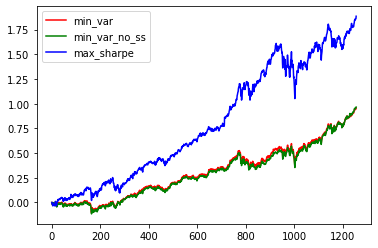

<Figure size 648x432 with 0 Axes>

In [26]:
def cum_returns(price):
    price = price[~np.isnan(price).any(axis=1)]
    returns = (price[1:,:] / price[0,:]) - 1
    return returns[~np.isnan(returns).any(axis=1)]

cum_r = cum_returns(px)
min_var_w_LM_r = portfolio_return(min_var_w_LM,cum_r)
min_var_w_no_ss_r = portfolio_return(min_var_w_no_ss,cum_r)
max_sharpe_w_no_ss_r = portfolio_return(max_sharpe_w_no_ss,cum_r)

# plot cummulative return using diff weights
plt.plot(min_var_w_LM_r, color='red', label="min_var")
plt.plot(min_var_w_no_ss_r, color='green', label="min_var_no_ss")
plt.plot(max_sharpe_w_no_ss_r, color='blue', label="max_sharpe")
plt.legend(loc="upper left")
plt.figure(figsize=(9, 6))

**For reference, display correlation heat map.**<br><br>
MSFT and V have the largest correlation among the stocks, and they are all positively correlated.

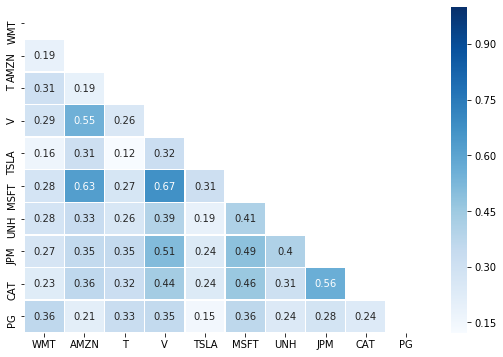

In [27]:
plt.figure(figsize=(9, 6))
sb.heatmap(corr, annot=True, mask=np.triu(corr),yticklabels=portfolio,xticklabels=portfolio,linewidths=.5,cmap="Blues")

**Summary**<br><br>
There are more to discover: <br>
1. The above code does not consider regular rebalancing, which is not the real practice. A more dynamic approach may have impacts on the result.
2. The above portfolio consists of US stocks only, which are highly correlated. The results could be more meaningful if multi-asset classes are analyzed.
3. Except minimize variance and maximize Sharpe ratio, there may be more appraoches. I will apply the concept of Eigen Vector in the next notebook.